In [15]:
# initial imports
import os
import pandas as pd
import matplotlib.pyplot as plt
import hvplot.pandas
import panel as pn
import plotly.express as px
from pathlib import Path
from panel.interact import interact

# Initialize the Panel Extensions (for Plotly)
pn.extension('plotly')

In [2]:
mapbox_token = "pk.eyJ1IjoicnlhbjExbGVlIiwiYSI6ImNrbjhnMTV6aTBxanUyb296dXRxcGRhczcifQ.O-3RGc50b9foVI0vBSjBow"

In [10]:
sf_data = pd.read_csv("sfo_neighborhoods_census_data.csv", index_col="year")
df_neighborhood_locations = pd.read_csv("neighborhoods_coordinates.csv")


In [11]:
# Define Panel Visualization Functions
def housing_units_per_year():
    """Housing Units Per Year."""

    
    housing_units = sf_data["housing_units"]
    housing_units = housing_units.groupby([sf_data.index]).mean()
    
    housing_units_fig = plt.figure()
    housing_units_plot = housing_units.plot.bar(x='year', ylim=[370000, 385000], title="Average Number of Housing Units Sold per Year")
    plt.close(housing_units_fig)
    
    return pn.pane.Matplotlib(housing_units_fig)

In [12]:
def average_gross_rent():  
    """Average Gross Rent in San Francisco Per Year."""
    

    
    average_rent_sqr_foot = sf_data["gross_rent"].groupby([sf_data.index]).mean()
    
    gross_rent_fig = plt.figure()
    average_rent_plot = (average_rent_sqr_foot.plot.line(x='year', y='gross_rent', title="Average Goss Rent per Year"))
    plt.close(gross_rent_fig)
    
    return pn.pane.Matplotlib(gross_rent_fig)

In [13]:
def average_sales_price():
    """Average Sales Price Per Year."""
    
    average_price_sqr_foot = sf_data["sale_price_sqr_foot"].groupby([sf_data.index]).mean()
    sales_price_fig = plt.figure()
    average_price_plot = (average_price_sqr_foot.plot.line(x='year', y='sale_price_sqr_foot', title="Average Sales Price per Year"))
    plt.close(sales_price_fig)
    
    return pn.pane.Matplotlib(sales_price_fig)

In [16]:
def average_price_by_neighborhood(neighborhood):
    """Average Prices by Neighborhood."""
    
    sf_data_new = sf_data.groupby([sf_data.index, "neighborhood"]).mean()
    sfo_sales = sf_data_new["sale_price_sqr_foot"]
    sfo_sales_df = pd.DataFrame(sfo_sales).reset_index()
     
    
    return sfo_sales_df.loc[sfo_sales_df['neighborhood']==neighborhood,:].hvplot.line(
        x="year",
        y="sale_price_sqr_foot",
        colormap="coolwarm",
        title="SF Sale per Square foot per Year",
    )

sf_data_new = sf_data.groupby([sf_data.index, "neighborhood"]).mean()
sfo_sales = sf_data_new["sale_price_sqr_foot"]
sfo_sales_df = pd.DataFrame(sfo_sales).reset_index()
neighborhood_choice = sfo_sales_df["neighborhood"].unique()
interact(average_price_by_neighborhood, neighborhood=neighborhood_choice)

Column
    [0] Column
        [0] Select(name='neighborhood', options=['Alamo Square', ...], value='Alamo Square')
    [1] Row
        [0] HoloViews(Curve, name='interactive01554')

In [17]:
def top_most_expensive_neighborhoods():
    """Top 10 Most Expensive Neighborhoods."""
    
    avg_value_per_neighborhood = sf_data.groupby([sf_data["neighborhood"]]).mean()
    avg_value_per_neighborhood = avg_value_per_neighborhood.reset_index()
    top_10_most_expensive = avg_value_per_neighborhood.nlargest(10, 'sale_price_sqr_foot').reset_index()
    top10_plot = px.bar(top_10_most_expensive,
    x="neighborhood", 
    y="sale_price_sqr_foot", 
    title="Top 10 Most Expensive Neighborhoods in San Francisco", 
    )

    return top10_plot

In [18]:
def parallel_coordinates():
    """Parallel Coordinates Plot."""
    
    avg_value_per_neighborhood = sf_data.groupby([sf_data["neighborhood"]]).mean()    
    top_10_most_expensive = avg_value_per_neighborhood.nlargest(10, 'sale_price_sqr_foot').reset_index()
    top_10_parallel = px.parallel_coordinates(
    top_10_most_expensive, 
    color='sale_price_sqr_foot')

    return top_10_parallel

In [25]:
def parallel_categories():
    """Parallel Categories Plot."""
    
    avg_value_per_neighborhood = sf_data.groupby([sf_data["neighborhood"]]).mean()  
    top_10_ex_neighborhood = avg_value_per_neighborhood.nlargest(10, 'sale_price_sqr_foot').reset_index()
    top_10_parallel_categories = px.parallel_categories(
    top_10_ex_neighborhood,
    dimensions=["neighborhood", "sale_price_sqr_foot", "housing_units", "gross_rent"],
    color="sale_price_sqr_foot",
)

    return top_10_parallel_categories

In [40]:
def sunburst():
    """Sunburst  Plot."""
    
    avg_value_per_neighborhood = sf_data.groupby([sf_data["neighborhood"]]).mean()    
    top_10_most_expensive = avg_value_per_neighborhood.nlargest(10, 'sale_price_sqr_foot').reset_index()
    top_10_sunburst = px.sunburst(
    top_10_most_expensive, 
    path=["neighborhood","housing_units"], values="sale_price_sqr_foot")

    return top_10_sunburst

In [46]:
def neighborhood_map():
    """Neighborhood Map"""
    
    file_path = Path("neighborhoods_coordinates.csv")
    df_neighborhood_location = pd.read_csv(file_path)
    avg_value_per_neighborhood = sf_data.groupby([sf_data["neighborhood"]]).mean()  
    avg_value_per_neighborhood = avg_value_per_neighborhood.reset_index()
    avg_value_location = pd.concat([avg_value_per_neighborhood, df_neighborhood_location], axis="columns", join="inner")

    location_map = px.scatter_mapbox(
    avg_value_location,
    lat="Lat",
    lon="Lon",
    size="sale_price_sqr_foot",
    color="gross_rent",
    zoom=11,
    width=800,
)
    

    return pn.pane.Plotly(location_map)


In [47]:
title = '#Real Estate Analysis'
welcome_tab = pn.Row(pn.Column(title), neighborhood_map())

market_analysis_row = pn.Row(housing_units_per_year(), average_gross_rent(), average_sales_price())


neighborhood_analysis_tab = pn.Column(interact(average_price_by_neighborhood, neighborhood=neighborhood_choice),
    top_most_expensive_neighborhoods()
)

parallel_plots_tab = pn.Column( 
    parallel_categories(),
    parallel_coordinates(),
    sunburst()
)


# Create tabs

SF_dashboard = pn.Tabs(("Welcome", welcome_tab), 
("Yearly Market Analysis", market_analysis_row),
("Neighborhood Analysis", neighborhood_analysis_tab), 
("Interactive Market Analysis by Neighborhood", parallel_plots_tab))

Tabs
    [0] Row
        [0] Column
            [0] Markdown(str)
        [1] Plotly(Figure)
    [1] Row
        [0] Matplotlib(Figure)
        [1] Matplotlib(Figure)
        [2] Matplotlib(Figure)
    [2] Column
        [0] Column
            [0] Column
                [0] Select(name='neighborhood', options=['Alamo Square', ...], value='Alamo Square')
            [1] Row
                [0] HoloViews(Curve, name='interactive03058')
        [1] Plotly(Figure)
    [3] Column
        [0] Plotly(Figure)
        [1] Plotly(Figure)
        [2] Plotly(Figure)
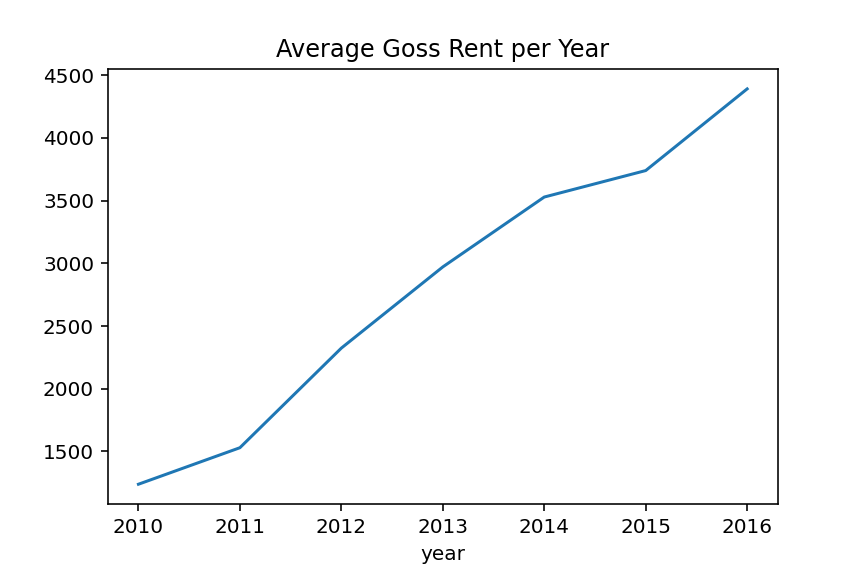
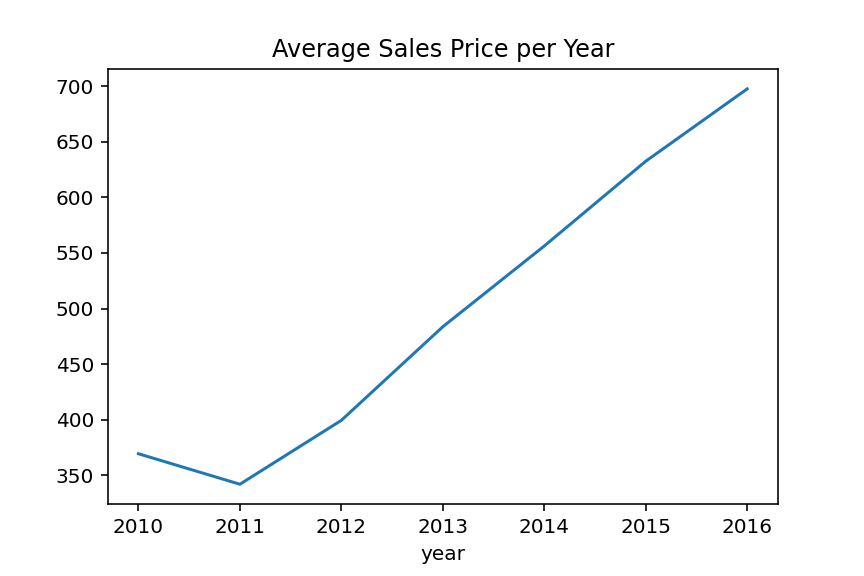
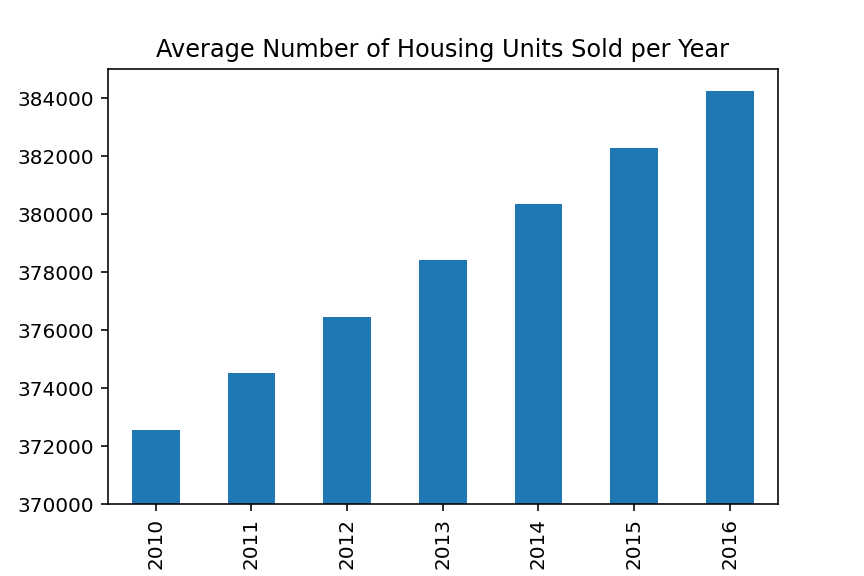

In [48]:
SF_dashboard.servable()


In [ ]:
! panel serve --show --port 5019 untitled.ipynb


2021-04-08 00:29:08,507 Starting Bokeh server version 2.3.1 (running on Tornado 6.1)
2021-04-08 00:29:08,510 User authentication hooks NOT provided (default user enabled)
2021-04-08 00:29:08,514 Bokeh app running at: http://localhost:5019/untitled
2021-04-08 00:29:08,514 Starting Bokeh server with process id: 35832
2021-04-08 00:29:12,575 404 GET /favicon.ico (::1) 0.60ms
2021-04-08 00:29:12,579 WebSocket connection opened
2021-04-08 00:29:12,580 ServerConnection created
